In [26]:
# Cell A
# load data
import os

github_path = "https://raw.githubusercontent.com/najoungkim/COGS/main/data"
data = {}

for name in ["train", "dev", "test", "gen"]:
    url = os.path.join(github_path, "{}.tsv".format(name))
    filepath = os.path.join("data", "{}.tsv".format(name))

    if not os.path.isfile(filepath):
        os.system(f"wget -O {filepath} {url}")

    assert os.path.isfile(filepath)
    with open(filepath, "r") as f:
        lines = f.readlines()

    lines = map(lambda x: x.strip(), lines)
    lines = map(lambda x: x.split("\t")[0], lines)
    data[name] = list(lines)

# Look at the data
for name in ["train", "dev", "test", "gen"]:
    print("=== {} ({} sentences) ===".format(name.upper(), len(data[name])))
    print("\n".join(data[name][:10]))

--2025-02-04 22:54:05--  https://raw.githubusercontent.com/najoungkim/COGS/main/data/train.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4146574 (4,0M) [text/plain]
Saving to: ‘data/train.tsv’

     0K .......... .......... .......... .......... ..........  1% 5,34M 1s
    50K .......... .......... .......... .......... ..........  2% 6,52M 1s
   100K .......... .......... .......... .......... ..........  3% 30,5M 0s
   150K .......... .......... .......... .......... ..........  4% 35,0M 0s
   200K .......... .......... .......... .......... ..........  6% 9,25M 0s
   250K .......... .......... .......... .......... ..........  7% 35,9M 0s
   300K .......... .......... .......... .......... ..........  8% 36,2M 0s
   350K .......... .......... ......

=== TRAIN (24155 sentences) ===
A rose was helped by a dog .
The sailor dusted a boy .
Emma rolled a teacher .
Evelyn rolled the girl .
A cake was forwarded to Levi by Charlotte .
The captain ate .
The girl needed to cook .
A cake rolled .
The cookie was passed to Emma .
Emma ate the ring beside a bed .
=== DEV (3000 sentences) ===
Liam hoped that a box was burned by a girl .
The donkey lended the cookie to a mother .
A melon was given to a girl by the guard .
A donut was given to a butterfly .
A rose was mailed to Isabella .
The girl offered the weapon beside a machine to a chicken .
A donut was touched by Emma .
Liam painted a box on a table beside the chair .
Emma ate a hammer .
A drink was juggled .
=== TEST (3000 sentences) ===
Mila liked that the cake was offered to Emma .
A coach supported that the cake was snapped .
The moose wanted to read .
A box was given to the cat by Aiden .
Emma cleaned the boy .
The dog painted the boy .
The sailor cleaned .
The customer held the priest 

200 OK
Length: 5532102 (5,3M) [text/plain]
Saving to: ‘data/gen.tsv’

     0K .......... .......... .......... .......... ..........  0% 5,06M 1s
    50K .......... .......... .......... .......... ..........  1% 6,50M 1s
   100K .......... .......... .......... .......... ..........  2% 20,3M 1s
   150K .......... .......... .......... .......... ..........  3% 8,81M 1s
   200K .......... .......... .......... .......... ..........  4% 42,7M 1s
   250K .......... .......... .......... .......... ..........  5% 37,6M 0s
   300K .......... .......... .......... .......... ..........  6% 37,5M 0s
   350K .......... .......... .......... .......... ..........  7% 13,9M 0s
   400K .......... .......... .......... .......... ..........  8% 36,4M 0s
   450K .......... .......... .......... .......... ..........  9% 35,5M 0s
   500K .......... .......... .......... .......... .......... 10% 41,5M 0s
   550K .......... .......... .......... .......... .......... 11% 40,5M 0s
   600K ..........

In [2]:
# Cell B
# Tokenization
# The final period is separated with a white space from the final word. This is a basic form of tokenization.
# The same is done as a pre-processing step with all punctuation (comma, question mark...).
# Turn sentences into lists of tokens: (here, token = word or punctuation mark; more generally, any sequence of ascii considered a unit)
for name in data:
    data[name] = list(map(lambda x: x.split(), data[name]))

# Normalization
# Here, uppercase vs lowercase is not so useful, and it just increases the size of the vocabulary (see below).
# So, let's turn all words into lowercase. Other possible normalization includes stemming.
# After this last stage of pre-processing, we have tokens.
tokens = {}
for name in data:
    tokens[name] = list(map(lambda x: [y.lower() for y in x], data[name]))

# Finally, add beginning-of-sentence and end-of-sentence tokens
for name in tokens:
    tokens[name] = list(map(lambda x: ["<bos>"] + x + ["<eos>"], tokens[name]))

In [3]:
# Cell C
# Vocabulary
# Let's set up the alphabet (noted V during the lecture), usually called vocabulary to avoid confusion
class Vocabulary:
    def __init__(self):
        self.vocab = set()

    def add(self, word):
        self.vocab.add(word)

    def process(self, sentence):
        assert isinstance(sentence, list) or isinstance(sentence, tuple)
        assert all(isinstance(x, str) for x in sentence)
        self.vocab.update(set(sentence))

    def size(self):
        return len(self.vocab)


# Create the vocabulary from the training data
vocabulary = Vocabulary()
for sentence in tokens["train"]:
    vocabulary.process(sentence)
# Q1: What is the size of the vocabulary?

**Cell C Q1: What is the size of the vocabulary?**


In [4]:
print(f"The size of the vocabulary is {vocabulary.size()}")

The size of the vocabulary is 743


In [5]:
# Cell D
# n-gram model
import math


class Probability:
    # special class to store small probabilities
    def __init__(self, p, log_scale=False):
        if log_scale:
            assert p >= 0, p
            self.value = p
        else:
            assert p <= 1, p
            assert p >= 0, p
            if p == 0:
                self.value = float("inf")
            else:
                self.value = -math.log(p)

    def get_p(self):
        p = math.exp(-self.value)
        assert p >= 0, p
        assert p <= 1, p
        return p

    def multiply(self, p):
        assert isinstance(p, Probability)
        self.value += p.value


class NgramCounter:
    def __init__(self, n, smoothing=0):
        assert isinstance(n, int)
        assert n > 0
        assert isinstance(smoothing, int)
        assert smoothing >= 0
        self.n = n  # the length of ngrams that we store
        self.smoothing = smoothing
        self.ngrams = {}
        self.vocab = Vocabulary()

    def count(self, ngram):
        assert isinstance(ngram, tuple)
        assert len(ngram) <= self.n
        self.ngrams.setdefault(ngram, 0)
        self.ngrams[ngram] += 1
        self.vocab.process(ngram)

    def shorten_history(self, history, max_length=None):
        if max_length is None:
            max_length = self.n - 1
        if max_length == 0:
            return []
        if len(history) > max_length:
            history = history[-max_length:]
        return history

    def process(self, tokens):
        assert isinstance(tokens, list)
        assert all(isinstance(x, str) for x in tokens)
        for tt in range(len(tokens)):
            for ll in range(1, self.n + 1):  # we need to count all lengths of ngrams
                if tt + ll > len(tokens):
                    break
                ngram = tokens[tt : tt + ll]
                self.count(tuple(ngram))

    def get_count(self, ngram, history=False):
        if isinstance(ngram, str):
            count = self.ngrams.get((ngram,), 0)
        else:
            count = self.ngrams.get(tuple(ngram), 0)
        if history:
            count += self.smoothing * self.vocab.size()
        else:
            count += self.smoothing
        return count

    def get_unigram_count(self):
        output = 0
        for ngram, count in self.ngrams.items():
            if len(ngram) == 1:
                output += count
        output += self.smoothing * self.vocab.size()
        return output

    def conditional_probability(self, token, history):
        # return p(token | history)
        assert isinstance(token, str)
        assert isinstance(history, list)
        assert all(isinstance(x, str) for x in history)
        history = self.shorten_history(history)
        ngram = tuple(history) + (token,)
        count = self.get_count(ngram)
        assert count is not None, ngram
        if len(history) == 0:
            Z = self.get_unigram_count()
            assert Z > 0, Z
            return Probability(count / Z)
        else:
            Z = self.get_count(history, history=True)
            assert Z > 0, "{}: {}".format(history, Z)
            return Probability(count / Z)

    def probability(self, tokens):
        logprob = self.compute_logprob(tokens)
        return logprob.get_p()

    def compute_logprob(self, tokens):
        probs = [None for _ in tokens]
        for tt in range(len(tokens)):
            history = tokens[:tt]
            cp = self.conditional_probability(tokens[tt], history)
            probs[tt] = cp
        assert all(x is not None for x in probs)
        logprob = sum(x.value for x in probs)
        logprob = Probability(logprob, log_scale=True)
        return logprob

    def perplexity(self, tokens):
        logprob = self.compute_logprob(tokens)
        perplexity = Probability(logprob.value / len(tokens), log_scale=True)
        return perplexity.value

    def get_top_ngrams(self, length=None, n=10):
        ngrams = sorted(self.ngrams.items(), key=lambda x: (-x[1], x[0]))
        if length is not None:
            ngrams = list(filter(lambda x: len(x[0]) == length, ngrams))
        return ngrams[:n]

In [6]:
# Cell E
# build ngram model
def fit(model, data):
    for sentence in data:
        model.process(sentence)


ngram_model = NgramCounter(25)
fit(ngram_model, tokens["train"])

**Cell F Q2: What do you expect the following probabilities to be? Why?**

1. I expect P(\<eos\>|.) to be 1, since a period is always followed by an end of sentence token, (e.g. all sentences end with a period).
2. I expect P(\<eos\>|\<bos\>) to be 0, since a beginning of sentence token is never followed by an end of sentence token. This would mean that we have an empty sentence (e.g. \<bos\>\<eos\>).


In [7]:
# Cell F
# Q2: What do you expect the following probabilities to be? Why?
print(ngram_model.conditional_probability("<eos>", ["."]).get_p())
print(ngram_model.conditional_probability("<eos>", ["<bos>"]).get_p())

1.0
0.0


In [8]:
# Cell G
# Look at the top ngrams
for n in range(1, ngram_model.n + 1):
    print("=== {} ===".format(n))
    top_ngrams = ngram_model.get_top_ngrams(length=n)
    for x in top_ngrams:
        print("{}: {}".format(*x))

=== 1 ===
('<bos>',): 24155
('<eos>',): 24155
('.',): 24012
('the',): 20237
('a',): 20153
('was',): 11650
('by',): 6985
('to',): 5901
('cake',): 4847
('girl',): 4625
=== 2 ===
('.', '<eos>'): 24012
('<bos>', 'a'): 8255
('<bos>', 'the'): 8198
('the', 'cake'): 2444
('a', 'cake'): 2403
('the', 'girl'): 2333
('a', 'girl'): 2291
('cake', 'was'): 2177
('<bos>', 'emma'): 1999
('by', 'the'): 1791
=== 3 ===
('girl', '.', '<eos>'): 1669
('emma', '.', '<eos>'): 1537
('the', 'cake', 'was'): 1118
('a', 'cake', 'was'): 1059
('<bos>', 'the', 'girl'): 1031
('<bos>', 'a', 'girl'): 1020
('<bos>', 'the', 'cake'): 981
('<bos>', 'a', 'cake'): 924
('by', 'emma', '.'): 922
('was', 'given', 'to'): 866
=== 4 ===
('<bos>', 'the', 'cake', 'was'): 961
('by', 'emma', '.', '<eos>'): 922
('<bos>', 'a', 'cake', 'was'): 906
('a', 'girl', '.', '<eos>'): 842
('the', 'girl', '.', '<eos>'): 827
('by', 'the', 'girl', '.'): 511
('by', 'a', 'girl', '.'): 475
('<bos>', 'a', 'donut', 'was'): 432
('by', 'liam', '.', '<eos>'): 4

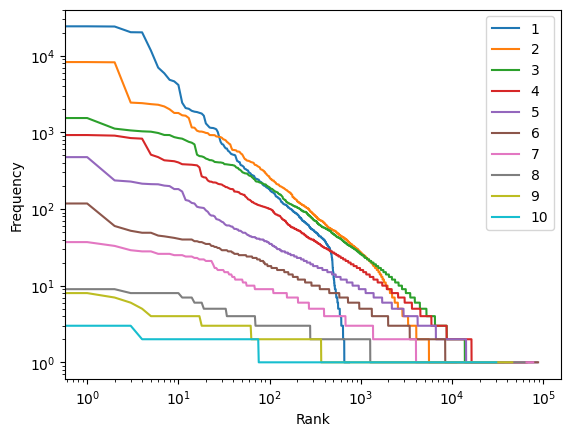

In [ ]:
# Cell H
# Zipf's law https://en.wikipedia.org/wiki/Zipf's_law
# Q3: Run this code to produce a plot. What does this plot show? What is on the x-axis, what is on the y-axis?
# Q4: According to this plot, is the ngram assumption justified? If you don't remember what the ngram assumption is, ask Nils.
%matplotlib ipympl
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np


def get_ngram_frequencies(n):
    frequencies = filter(lambda x: len(x[0]) == n, ngram_model.ngrams.items())
    frequencies = map(lambda x: x[1], frequencies)
    y = sorted(frequencies, reverse=True)
    x = np.arange(len(y))
    if len(x) == 0:
        return None, None
    else:
        return x, y


fig, ax = plt.subplots()
ax.set_xscale("log")
ax.set_yscale("log")
for n in range(1, 11):
    x, y = get_ngram_frequencies(n)
    if x is None:
        continue
    ax.plot(x, y, label=n)

ax.set_xlabel("Rank")
ax.set_ylabel("Frequency")
ax.legend()
plt.show()

**Cell H Q3: Run this code to produce a plot. What does this plot show? What is on the x-axis, what is on the y-axis?**

This is the plot of the so called Zipf's law. The x-axis shows the rank of the word in the vocabulary, and the y-axis shows the frequency of the word. The plot shows that the frequency of a word is inversely proportional to its rank in the vocabulary.

**Cell H Q4: According to this plot, is the ngram assumption justified? If you don't remember what the ngram assumption is, ask Nils.**

The ngram assumption is that the probability of a word depends only on the previous n-1 words.
In the plot we can see that two distinct trends:

- For small n, the ngram assumption is justified: the n-grams are more frequent and are able to capture more information
- For large n, the ngram assumption is not justified: the frequency of n-grams decreases rapidly, leading to data sparsity. This sparsity makes it difficult to estimate reliable probabilities, as many higher-order n-grams appear rarely or not at all in the dataset.


In [10]:
# Cell I
# Perplexity
from tqdm import tqdm


def dataset_perplexity(model, data, progress=False, details=False):
    output = 0
    samples = [] if details else None
    it = tqdm(data) if progress else data
    for sentence in it:
        perplexity_ = model.perplexity(sentence)
        output += perplexity_
        if samples is not None:
            samples.append((sentence, perplexity_))
    output /= len(data)
    if details:
        return output, sorted(samples, key=lambda x: x[1])
    else:
        return output


# Q5: Why does this throw an error?
perplexity = dataset_perplexity(ngram_model, tokens["dev"])

AssertionError: ['<bos>', 'liam', 'hoped', 'that', 'a', 'box']: 0

**Cell I Q5: Why does this throw an error?**

Looking at the assertion message and at the "dev" dataset, we understand that we are trying to compute the following probability: P("was"|"box", "a", "hoped", "liam", "\<bos\>").
However, the 5-gram "box a hoped liam \<bos\>" does not appear in the training data. The model has never seen this 5-gram (the assertion checks if the history has been seen at least once in the training data). Therefore, the model cannot compute the requested probability.

To confirm this, we can check the training data to see if the 5-gram "box a hoped liam \<bos\>" appears in the training data.
We can see that the only sentences starting with "\<bos\> Liam hoped that a" are the following:

- Liam hoped that a beer
- Liam hoped that a judge
- Liam hoped that a girl
- Liam hoped that a girl

Therefore, we are now sure that the 5-gram "box a hoped liam \<bos\>" does not appear in the training data.


In [11]:
# Cell J
# Try again, but with "smoothing = 1"
# "smoothing" adds counts to unknown ngrams. No probability is equal to 0 anymore,
# but we give probability mass away that could be used for known ngrams.
ngram_model = NgramCounter(25, smoothing=1)
fit(ngram_model, tokens["train"])
perplexity = dataset_perplexity(ngram_model, tokens["dev"], progress=True)
print(perplexity)

100%|██████████| 3000/3000 [02:21<00:00, 21.14it/s]

5.034350787496001


In [12]:
# Cell K
# small grid search: find the best possible length for ngrams, and the best possible smoothing value
# while this runs, get up and stretch your legs
import itertools

n_values = [1, 2, 3, 4]
smoothing_values = [1, 2, 4]
params = list(itertools.product(*[n_values, smoothing_values]))
for param in itertools.product(*[n_values, smoothing_values]):
    n, smoothing = param
    ngram_model = NgramCounter(n, smoothing=smoothing)
    fit(ngram_model, tokens["train"])
    perplexity = dataset_perplexity(ngram_model, tokens["dev"])
    print("n={}, smoothing={}, perplexity={}".format(n, smoothing, perplexity))
# Q6: Why doesn't the dev perplexity keep decreasing as n increases?

n=1, smoothing=1, perplexity=3.9453247352681817
n=1, smoothing=2, perplexity=3.9457556107640968
n=1, smoothing=4, perplexity=3.946914983054919
n=2, smoothing=1, perplexity=2.866494635486315
n=2, smoothing=2, perplexity=3.017926706992085
n=2, smoothing=4, perplexity=3.2023672810157295
n=3, smoothing=1, perplexity=3.5740829970905956
n=3, smoothing=2, perplexity=3.838071246341628
n=3, smoothing=4, perplexity=4.11857556451489
n=4, smoothing=1, perplexity=4.227705632549121
n=4, smoothing=2, perplexity=4.45331717241929
n=4, smoothing=4, perplexity=4.673877224641809


**Cell K Q6: Why doesn't the dev perplexity keep decreasing as n increases?**

As explained before, as n increases, the n-grams become less frequent and the data sparsity increases.
With smoothing we can mitigate this problem, but we have to make trade-offs between the quantity of information we can capture (high n-grams capture more information) and the generalization of the model (low n-grams generalize better).

To summarize, it's not obvious that increasing n will always lead to a lower perplexity.


**Cell L Q7: What are the best values for n and smoothing?**

The best values for n and smoothing are the ones that minimize the perplexity on the dev set. In this case, the best values are n=2 and smoothing=1.


In [13]:
# Cell L
# Q7: What are the best values for n and smoothing?
best_n = 2  # TODO
best_smoothing = 1  # TODO

# Q8: How many parameters does the best ngram model have? Explain how you compute this quantity.
best_ngram_model = NgramCounter(best_n, smoothing=best_smoothing)
fit(best_ngram_model, tokens["train"])

**Cell L Q8: How many parameters does the best ngram model have? Explain how you compute this quantity.**

Generally, the number of parameters of an n-gram model is the number of unique n-grams in the training data.

Theoretically, the number of parameters should be given by $|V|^n$ where $|V|$ is the size of the vocabulary and $n$ is the order of the n-gram model. However, in practice, we have to consider that some n-grams may not appear in the training data, so the number of parameters will be less than $|V|^n$.

In our case, we are working with a bigram model, so the theoretical number of parameters should be given by $|V|^2$ = 743^2 = 552049.
Nevertheless we can see that the real number of parameters is only 11831.


In [14]:
n_params = len(best_ngram_model.ngrams)
print(f"Total number of parameters in the best ngram model: {n_params}")

Total number of parameters in the best ngram model: 11831


In [15]:
# Cell M
# Build the best model on train and dev using the parameters for n and smoothing found in cell L.
# Then compute its perplexity on test and gen.
# Q9: What do you notice?
best_n = 2  # TODO
best_smoothing = 1  # TODO
ngram_model = NgramCounter(best_n, smoothing=best_smoothing)
fit(ngram_model, tokens["train"] + tokens["dev"])
for split in ["train", "dev", "test", "gen"]:
    perplexity = dataset_perplexity(ngram_model, tokens[split], progress=True)
    print("{}: {}".format(split, perplexity))

100%|██████████| 24155/24155 [00:25<00:00, 954.34it/s]


train: 2.8175040322146168


100%|██████████| 3000/3000 [00:03<00:00, 922.96it/s]


dev: 2.8046599676159962


100%|██████████| 3000/3000 [00:03<00:00, 935.80it/s]


test: 2.83545168799614


100%|██████████| 21000/21000 [00:22<00:00, 942.15it/s]

gen: 3.77050249563234


**Cell M Q9: What do you notice?**

The perplexity of the model is similar for the text, the dev and the test sets.
This means that the model generalizes well to unseen data and did not overfit the training data.

However, the perplexity of the model is higher for the gen set.


In [16]:
# Cell N
# RNN LM
# Q10: How does this RNN LM deal with words outside of its vocabulary?
import torch
from torch import nn
import itertools


# redefine this helper class
class Vocabulary:
    def __init__(self, words=set()):
        self.vocab = set(words)
        self.unk = "<unk>"
        self.bos = "<bos>"
        self.eos = "<eos>"
        self.vocab.add(self.unk)
        self.vocab.add(self.bos)
        self.vocab.add(self.eos)
        self.vocab = sorted(self.vocab)

    def add(self, word):
        if word not in self.vocab:
            self.vocab.append(word)

    def process(self, sentence):
        assert isinstance(sentence, list) or isinstance(sentence, tuple)
        assert all(isinstance(x, str) for x in sentence)
        for word in sentence:
            self.add(word)

    def size(self):
        return len(self.vocab)

    def word_to_int(self, word):
        assert isinstance(word, str)
        if word in self.vocab:
            key = word
        else:
            key = self.unk
        return self.vocab.index(key)

    def sentence_to_int(self, sentence):
        output = [None for _ in sentence]
        for ii, token in enumerate(sentence):
            output[ii] = self.word_to_int(token)
        return output


class RNNLM(nn.Module):
    def __init__(self, vocab=None, n_layers=2, n_units=512):
        super(RNNLM, self).__init__()
        assert isinstance(n_layers, int)
        assert n_layers > 0
        self.n_layers = n_layers
        assert isinstance(n_units, int)
        assert n_units > 0
        self.n_units = n_units
        assert isinstance(vocab, Vocabulary)
        self.vocab = vocab
        self.padding = self.vocab.size()
        # model parameters
        # dense word embeddings
        self.embeddings = nn.Embedding(
            self.vocab.size() + 1, self.n_units, padding_idx=self.padding
        )
        # recurrent neural network
        self.rnn = nn.LSTM(
            self.n_units, self.n_units, num_layers=self.n_layers, batch_first=True
        )
        # final projection layer
        self.projection = nn.Sequential(
            nn.Linear(self.n_units, self.vocab.size()), nn.LogSoftmax(2)
        )

    def forward(self, batch):
        assert isinstance(batch, list), batch
        assert all(isinstance(x, list) for x in batch), batch
        assert all(all(isinstance(x, str) for x in sentence) for sentence in batch)
        assert all(x[0] == self.vocab.bos for x in batch)
        assert all(x[-1] == self.vocab.eos for x in batch)
        # turn into indices
        indices = [self.vocab.sentence_to_int(x) for x in batch]
        # pad
        max_len = max(len(x) for x in indices)
        indices = [
            x if len(x) == max_len else x + [self.padding] * (max_len - len(x))
            for x in indices
        ]
        # turn into tensor
        indices = torch.tensor(indices)
        # feed through model
        word_embeddings = self.embeddings(indices)
        rnn_outputs, _ = self.rnn(word_embeddings)
        logits = self.projection(rnn_outputs)
        return logits, indices

    def perplexity(self, sentence):
        assert isinstance(sentence, list), sentence
        assert all(isinstance(x, str) for x in sentence)
        assert sentence[0] == self.vocab.bos, sentence
        assert sentence[-1] == self.vocab.eos, sentence
        logits, indices = self.forward([sentence])
        logits = logits[0, :-1, :]
        indices = indices[0, 1:]
        # there is probably a better way for the following
        perplexity = 0
        for tt, index in enumerate(indices.numpy().tolist()):
            perplexity += logits[tt, index].item()
        perplexity = -perplexity / len(sentence)
        return perplexity

    def batch_perplexity(self, batch):
        assert isinstance(batch, list), batch
        assert all(isinstance(x, list) for x in batch), batch
        assert len(batch) > 0
        perplexities = [self.perplexity(sentence) for sentence in batch]
        return sum(perplexities) / len(perplexities)

    def number_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)


class Trainer:
    def __init__(self, model, data, batch_size=128):
        self.model = model
        self.data = data
        self.optimizer = torch.optim.Adam(self.model.parameters())
        assert isinstance(batch_size, int)
        assert batch_size > 0
        self.batch_size = batch_size
        self.loss_function = nn.CrossEntropyLoss(
            ignore_index=self.model.padding, size_average=True
        )

    def step(self, split, position, grad=False):
        start = position
        end = min(start + self.batch_size, len(self.data[split]))
        batch = self.data[split][start:end]
        logits, indices = self.model.forward(batch)
        targets = indices[:, 1:]
        logits = logits[:, :-1, :]
        assert logits.size(0) == targets.size(0)
        assert logits.size(1) == targets.size(1)
        logits = torch.reshape(logits, (-1, self.model.vocab.size()))
        targets = torch.reshape(targets, (-1,))
        loss = self.loss_function(logits, targets)
        if grad:
            self.optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(self.model.parameters(), 5)
            self.optimizer.step()
        return loss

    def train(self, num_epochs, verbose=False):
        for epoch in range(num_epochs):
            train_loss = 0
            num_steps = 0
            it = (
                tqdm(range(0, len(self.data["train"]), self.batch_size))
                if verbose
                else range(0, len(self.data["train"]), self.batch_size)
            )
            for position in it:
                loss_ = self.step("train", position, grad=True)
                train_loss += loss_.item()
                num_steps += 1
            train_loss /= num_steps
            dev_loss = 0
            num_steps = 0
            it = (
                tqdm(range(0, len(self.data["dev"]), self.batch_size))
                if verbose
                else range(0, len(self.data["dev"]), self.batch_size)
            )
            for position in it:
                loss_ = self.step("dev", position, grad=False)
                dev_loss += loss_
                num_steps += 1
            dev_loss /= num_steps
            print(
                "epoch {}/{}; train loss {}; dev loss {}".format(
                    epoch + 1, num_epochs, train_loss, dev_loss
                )
            )

**Cell N Q10: How does this RNN LM deal with words outside of its vocabulary?**

The model deals with words outside of its vocabulary by replacing them with the \<unk\> token, as we can see in this snippet of code:

```python
if word in self.vocab:
    key = word
else:
    key = self.unk
```


In [17]:
# Cell O
# Train RNN LM
vocabulary = Vocabulary()
for sentence in tokens["train"]:
    vocabulary.process(sentence)
rnn_lm = RNNLM(vocab=vocabulary, n_layers=1, n_units=7)
print(rnn_lm)
print("number of parameters: {}".format(rnn_lm.number_parameters()))
trainer = Trainer(rnn_lm, tokens)
print("get up and stretch your legs while this runs")
trainer.train(100)
# Q11: How do the number of parameters of this model compare to the number of parameters of the best ngram model?

RNNLM(
  (embeddings): Embedding(745, 7, padding_idx=744)
  (rnn): LSTM(7, 7, batch_first=True)
  (projection): Sequential(
    (0): Linear(in_features=7, out_features=744, bias=True)
    (1): LogSoftmax(dim=2)
  )
)
number of parameters: 11615


/home/ids/glorenzo-23/IA327-Generative-Models-for-NLP/venv/lib/python3.10/site-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


get up and stretch your legs while this runs
epoch 1/100; train loss 6.010851509356625; dev loss 4.971638202667236
epoch 2/100; train loss 4.410062363538793; dev loss 4.139423370361328
epoch 3/100; train loss 4.069676546823411; dev loss 4.0209527015686035
epoch 4/100; train loss 3.9493293598215415; dev loss 3.890148878097534
epoch 5/100; train loss 3.833683582840773; dev loss 3.7892942428588867
epoch 6/100; train loss 3.7256292640847506; dev loss 3.6632654666900635
epoch 7/100; train loss 3.5855166886849377; dev loss 3.519681692123413
epoch 8/100; train loss 3.438468853632609; dev loss 3.366128921508789
epoch 9/100; train loss 3.2850895949772427; dev loss 3.2145423889160156
epoch 10/100; train loss 3.1402417213197737; dev loss 3.08278489112854
epoch 11/100; train loss 3.0137999360523526; dev loss 2.962031602859497
epoch 12/100; train loss 2.9115868914064276; dev loss 2.8759310245513916
epoch 13/100; train loss 2.8321965081351146; dev loss 2.8017654418945312
epoch 14/100; train loss 2.7

**Cell O Q11: How do the number of parameters of this model compare to the number of parameters of the best ngram model?**

We have a comparable number of parameters for the RNN model and the best ngram model: the RNN model has 11615 parameters, while the best ngram model has 11831 parameters.

We can also notice that, at least theoretically, the number of parameters of the n-gram model grows exponentially with n, while the number of parameters of the RNN model grows linearly with the size of the vocabulary.


In [18]:
# Cell P
# Q12: How does the following compare to the best ngram model?
for split in ["train", "dev", "test", "gen"]:
    perplexity = dataset_perplexity(rnn_lm, tokens[split], progress=True)
    print("{}: {}".format(split, perplexity))

100%|██████████| 24155/24155 [00:27<00:00, 872.30it/s]


train: 1.8404611518776244


100%|██████████| 3000/3000 [00:03<00:00, 874.07it/s]


dev: 1.8407880543902686


100%|██████████| 3000/3000 [00:03<00:00, 881.66it/s]


test: 1.8355682023058824


100%|██████████| 21000/21000 [00:26<00:00, 806.36it/s]

gen: 3.265889494999178


**Cell P Q12: How does the following compare to the best ngram model?**

All the values of the perplexity are lower for the RNN model than for the best ngram model. This means that the RNN model, with the same number of parameters, is able to give stronger predictions.

Also in this case the perplexity is higher for the gen set, meaning that the model is not able to generalize well to unseen data.


In [19]:
# Cell Q
# Note that we underexploited at least 3 things:
# 1. The training time. The dev loss keeps decreasing, even after 200 epochs of training.
# See this by running trainer.train(100)
# 2. The RNN size. This RNN is *tiny* compared to what you'd use in practice. Here we just made it comparable to the best ngram model.
# 3. The data. Once we know at what epoch our RNN converges, we can train on train+dev, using the optimal epoch number as our stopping criterion.
# Q13: What else could we have done to further push the dev loss down?

**Cell Q Q13: What else could we have done to further push the dev loss down?**

Another possible improvement would have been to use more complex embeddings, such as pre-trained embeddings (e.g. GloVe, Word2Vec, etc.).


In [20]:
# Cell R
# Train larger RNN LM
vocabulary = Vocabulary()
for sentence in tokens["train"]:
    vocabulary.process(sentence)
rnn_lm_large = RNNLM(vocab=vocabulary, n_layers=2, n_units=512)
print(rnn_lm_large)
print("number of parameters: {}".format(rnn_lm_large.number_parameters()))
trainer_large = Trainer(rnn_lm_large, tokens)
print("get up and stretch your legs while this runs")
trainer_large.train(5)

RNNLM(
  (embeddings): Embedding(745, 512, padding_idx=744)
  (rnn): LSTM(512, 512, num_layers=2, batch_first=True)
  (projection): Sequential(
    (0): Linear(in_features=512, out_features=744, bias=True)
    (1): LogSoftmax(dim=2)
  )
)
number of parameters: 4965608
get up and stretch your legs while this runs
epoch 1/5; train loss 2.565265417098999; dev loss 2.0611073970794678
epoch 2/5; train loss 2.0344007803649498; dev loss 2.0205414295196533
epoch 3/5; train loss 2.0105512526930953; dev loss 2.013538360595703
epoch 4/5; train loss 2.0003159506611095; dev loss 2.0117030143737793
epoch 5/5; train loss 1.9928751717168818; dev loss 2.0106024742126465


In [21]:
# Cell S
# Q14: How does the following compare to the other models?
for split in ["train", "dev", "test", "gen"]:
    perplexity = dataset_perplexity(rnn_lm_large, tokens[split], progress=True)
    print("{}: {}".format(split, perplexity))

100%|██████████| 24155/24155 [02:18<00:00, 173.94it/s]


train: 1.800081846462163


100%|██████████| 3000/3000 [00:19<00:00, 150.82it/s]


dev: 1.817906498618834


100%|██████████| 3000/3000 [00:18<00:00, 163.63it/s]


test: 1.8124738938066893


100%|██████████| 21000/21000 [02:21<00:00, 148.32it/s]

gen: 2.9807881457798144


**Cell S Q14: How does the following compare to the other models?**

The perplexity is slightly lower. This indicates that increasing the model size can help to improve the performance of the model.


100%|██████████| 21000/21000 [00:23<00:00, 893.35it/s]


ngram on gen:
  perplexity: 3.77050249563234
  low perplexity:
    <bos> the girl in a box was given a cake . <eos> -- 1.9547718504713487
    <bos> the donut on the box was eaten by the girl on a table . <eos> -- 2.0409767526976643
    <bos> the donut beside the table was given to emma . <eos> -- 2.32142372733305
    <bos> a girl on the box was lended the balloon beside a table . <eos> -- 2.3282984587208677
    <bos> the cake in the room was given to liam . <eos> -- 2.3777834967263867
  high perplexity:
    <bos> charlie awarded matthew a jigsaw . <eos> -- 5.434826022015369
    <bos> charlie brought hazel the weapon . <eos> -- 5.443434029267843
    <bos> lily gave grayson a hedgehog . <eos> -- 5.459891409819
    <bos> david forwarded noah a shark . <eos> -- 5.4757450021315535
    <bos> lily gave grayson a shark . <eos> -- 5.546534807388993


100%|██████████| 3000/3000 [00:03<00:00, 885.79it/s]


ngram on test:
  perplexity: 2.83545168799614
  low perplexity:
    <bos> a donut was given to emma . <eos> -- 1.5535016266099089
    <bos> the cake was rolled by emma . <eos> -- 1.6013388855308628
    <bos> the cake was rolled . <eos> -- 1.60887585269117
    <bos> a cake was liked by the girl . <eos> -- 1.6210054267492218
    <bos> the cookie was given to emma . <eos> -- 1.6313994763531094
  high perplexity:
    <bos> joseph studied gabriel . <eos> -- 4.396597636527191
    <bos> mateo lended the princess the flag . <eos> -- 4.484398557443335
    <bos> the monkey served a penguin a leaf beside the baron . <eos> -- 4.503364231821037
    <bos> brooklyn gave a plate beside a machine to bella . <eos> -- 4.560904332255828
    <bos> stella gave david the sweetcorn . <eos> -- 4.998960534214915


100%|██████████| 21000/21000 [00:41<00:00, 501.41it/s]


rnn on gen:
  perplexity: 3.265889494999178
  low perplexity:
    <bos> the girl gave a cake on a stage in the house beside a table to a baby . <eos> -- 1.6444864137505646
    <bos> a girl liked that liam liked that a cat hoped that the cookie was adored . <eos> -- 1.8083977773785591
    <bos> emma liked a box on the seat on the table in the house . <eos> -- 1.8418825653207023
    <bos> emma rolled a boy beside a table in a house beside the chair in a room . <eos> -- 1.8430160654243082
    <bos> a boy supported that the child supported that a girl liked that a cake was burned . <eos> -- 1.8487911942954127
  high perplexity:
    <bos> paula loved amelia . <eos> -- 6.813363928968708
    <bos> paula observed abigail . <eos> -- 6.855535167851485
    <bos> paula knew claire . <eos> -- 6.903982962219743
    <bos> paula loved to run . <eos> -- 6.967401821407423
    <bos> paula loved to talk . <eos> -- 7.052773080026133


100%|██████████| 3000/3000 [00:07<00:00, 409.76it/s]


rnn on test:
  perplexity: 1.8355682023058824
  low perplexity:
    <bos> a cake was liked by the girl . <eos> -- 0.8623862284701318
    <bos> a cake was given to emma by the girl . <eos> -- 0.8987995020773573
    <bos> the cake was rolled by emma . <eos> -- 0.9077614748514153
    <bos> the cake was given to a boy by a girl . <eos> -- 0.9366408326448157
    <bos> a cake was liked by the boy . <eos> -- 0.9454096383531578
  high perplexity:
    <bos> charlotte observed harper . <eos> -- 3.0835725672077388
    <bos> grayson slid isabella . <eos> -- 3.1479500774488165
    <bos> the chief worshipped aubrey . <eos> -- 3.288493710545091
    <bos> stella gave david the sweetcorn . <eos> -- 3.3866220882046036
    <bos> joseph studied gabriel . <eos> -- 3.582405291837252


100%|██████████| 21000/21000 [03:50<00:00, 91.19it/s] 


rnn large on gen:
  perplexity: 2.9807881457798144
  low perplexity:
    <bos> the girl gave a cake on a stage in the house beside a table to a baby . <eos> -- 1.4982622889758204
    <bos> the girl teleported a donut beside the table to emma . <eos> -- 1.53979492997482
    <bos> a cat teleported the cake beside the table to a girl . <eos> -- 1.578037559463285
    <bos> a girl teleported a cake on a table to liam . <eos> -- 1.581358642800926
    <bos> a girl teleported a cake on a table to the dog . <eos> -- 1.6067087290263902
  high perplexity:
    <bos> jackson slipped zoey lina . <eos> -- 5.537133056587273
    <bos> levi offered emma lina . <eos> -- 5.541820447480339
    <bos> the shark saw claire . <eos> -- 5.549940083670663
    <bos> caleb sold ethan lina . <eos> -- 5.742768771667865
    <bos> leo rented lincoln lina . <eos> -- 5.807707149809825


100%|██████████| 3000/3000 [00:28<00:00, 106.67it/s]


rnn large on test:
  perplexity: 1.8124738938066893
  low perplexity:
    <bos> a cake was given to emma by the girl . <eos> -- 0.8772665648405867
    <bos> the cake was given to a boy by a girl . <eos> -- 0.8872672379735517
    <bos> a donut was given to a girl by emma . <eos> -- 0.9359596556520652
    <bos> the cake was found by the girl . <eos> -- 0.9522859799442813
    <bos> a cake was liked by the girl . <eos> -- 0.9529329613069422
  high perplexity:
    <bos> a kitty collapsed a passenger . <eos> -- 3.076913554021303
    <bos> nora pierced a doll . <eos> -- 3.081183515813401
    <bos> stella gave david the sweetcorn . <eos> -- 3.1079209614799765
    <bos> elijah admired camila . <eos> -- 3.180633073025092
    <bos> joseph studied gabriel . <eos> -- 3.874791677311199


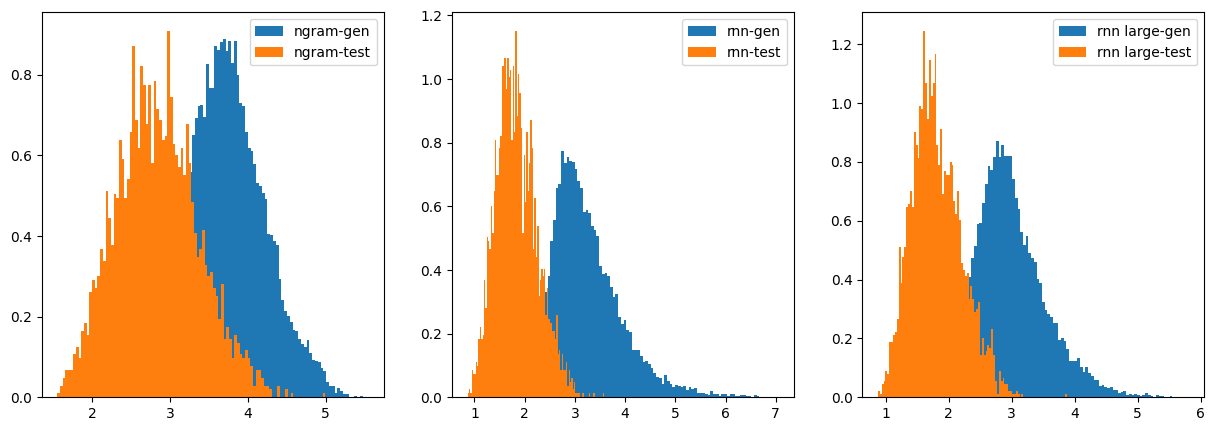

In [23]:
# Cell T
# Look at some high and low perplexity samples
# Look at overall distribution of perplexity
# Q15: What do you notice? Is there a phrase that describes this mismatch between distributions?
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
for ii, (name, model) in enumerate(
    [("ngram", ngram_model), ("rnn", rnn_lm), ("rnn large", rnn_lm_large)]
):
    for split in ["gen", "test"]:
        perplexity, samples = dataset_perplexity(
            model, tokens[split], progress=True, details=True
        )
        print("{} on {}:".format(name, split))
        print("  perplexity: {}".format(perplexity))
        print("  low perplexity:")
        low_p = ("    " + " ".join(x[0]) + " -- {}".format(x[1]) for x in samples[:5])
        print("\n".join(low_p))
        print("  high perplexity:")
        high_p = ("    " + " ".join(x[0]) + " -- {}".format(x[1]) for x in samples[-5:])
        print("\n".join(high_p))
        y = sorted((x[1] for x in samples), reverse=True)
        assert all(z > 0 for z in y)
        x = np.arange(len(y))
        # ax.plot(x, y, label='{}-{}'.format(name,split))
        ax[ii].hist(y, bins=100, density=True, label="{}-{}".format(name, split))
for ii, _ in enumerate(ax):
    ax[ii].legend()

**Cell T Q15: What do you notice? Is there a phrase that describes this mismatch between distributions?**

In all the cases, the perplexity is higher for the gen set (the mean of the perplexity is always higher for the gen set than for the test set).

We can see that both of the RNN models are able to reduce the perplexity on the test set, but not on the gen set. This is an example of **distribution shift**, where the test set is drawn from a similar distribution as the training set, while the gen set is drawn from a different distribution.

This shows the limitation of RNNs in generalizing to OOD data.
